# Starfysh tutorial on real dataset

**Azizi Lab**

Siyu He, Yinuo Jin

12-11-2022

This is a tutorial on an example real Spatial Transcriptomics (ST) [data](https://drive.google.com/drive/folders/1RIp0Z2eF1m8Ortx0sgB4z5g5ISsRFzJ4?usp=share_link) (`CID44971_TNBC`) from [Wu *et al.*, 2021](https://www.nature.com/articles/s41588-021-00911-1).

## Overview
Starfysh performs cell-type deconvolution followed by various downstream analysis to discover spatial interactions in tumor microenvironment. Specifically, Starfysh looks for *anchor spots*, the presumed purest spots with the highest proportion of a given cell type guided by signatures ([see example](https://drive.google.com/file/d/1yAfAj7PaFJZph88MwhWNXL5Kx5dKMngZ/view?usp=share_link)), and further deconvolve the remaining spots. Starfysh provides the following options:

**Base feature**:

- Auxiliary Variational AutoEncoder (AVAE):<br>
  Spot-level deconvolution with expected cell types and corresponding annotated *signature* gene sets (default)

**Optional**:

- Archetypal Analysis (AA):<br>

    *If signature is not provided*: (example updated soon!)
    
    - Unsupervised cell type annotation (if the input *signature* is not provided)

    *If signature is provided*:
    
    - Novel cell type / cell state discovery (complementary to known cell types from the *signatures*
    - Refine known marker genes by appending archetype-specific differentially expressed genes, and update anchor spots accordingly
    

- Product-of-Experts (PoE) integration:<br>
    *Example updated soon!*<br>
    
    Multi-modal integrative predictions with *expression* & *histology image* by leverging additional side information (e.g. cell density) from H&E image.


In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    !pip install git+https://github.com/azizilab/starfysh.git
    !pip install scikit-image --upgrade
    from google.colab import drive
    drive.mount('/content/drive')
    import sys

    # Please specify the colab notebook directory
    sys.path.append('/content/drive/MyDrive/Starfysh')

In [2]:
import os
import numpy as np
import pandas as pd
import torch

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

## Load starfysh

In [4]:
from starfysh import (utils,
                      plot_utils,
                      starfysh,
                      post_analysis,
                      AA
                     )

2022-12-11 17:44:07.155671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-11 17:44:07.155690: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### (1). load data and marker genes

File Input:
- Spatial transcriptomics
    - Count matrix: `adata`
    - (Optional): Paired histology & spot coordinates: `img`, `map_info`

- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_featyur_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For example, our example real ST data has the following structure:
```
├── ../data
    bc_signatures_version_1013.csv

    ├── P1A_ER:
        \__ filtered_feature_bc_mactrix.h5

        ├── spatial:
            \__ aligned_fiducials.jpg
                detected_tissue_image.jpg
                scalefactors_json.json
                tissue_hires_image.png
                tissue_lowres_image.png
                tissue_positions_list.csv
```

For data that doesn't follow the common visium data structure (e.g. missing `filtered_featyur_bc_matrix.h5` or the given `.h5ad` count matrix file lacks spatial metadata), please construct the data as Anndata synthesizing information as the example simulated data shows:

[Note]: If you're running this tutorial locally, please download the sample [data](https://drive.google.com/drive/folders/1RIp0Z2eF1m8Ortx0sgB4z5g5ISsRFzJ4?usp=share_link) and [signature gene sets](https://drive.google.com/file/d/1yAfAj7PaFJZph88MwhWNXL5Kx5dKMngZ/view?usp=share_link), and save it in the relative path `../data` (otherwise please modify the `data_path` defined in the cell below):

In [5]:
# Specify data paths
data_path = '../data/'
sample_id = 'CID44971_TNBC'
sig_name = 'bc_signatures_version_1013.csv'

In [6]:
# Load expression counts and signature gene sets
adata, adata_normed = utils.load_adata(data_folder=data_path,
                                       sample_id=sample_id, # sample id
                                       n_genes=2000  # number of highly variable genes to keep
                                       )

gene_sig = pd.read_csv(os.path.join(data_path, sig_name))
gene_sig = utils.filter_gene_sig(gene_sig, adata.to_df())
gene_sig.head()

[2022-12-11 17:44:08] Preprocessing1: delete the mt and rp
[2022-12-11 17:44:08] Preprocessing2: Normalize
[2022-12-11 17:44:08] Preprocessing3: Logarithm
[2022-12-11 17:44:08] Preprocessing4: Find the variable genes


Basal     LumA   LumB      MBC    CSC Normal epithelial    Tcm      Tem  \
0   EMP1  SH3BGRL   UGCG  COL11A2   CD44             KRT14   CCR7     IL7R   
1  TAGLN    HSPB1  ARMT1     SDC1    ESA             KRT17    LTB    ANXA1   
2  TTYH1    PHGR1  ISOC1     FBN2  CD133               LTF   IL7R    CXCR4   
3   RTN4     SOX9  GDF15     MMP1  ALDH1             KRT15  SARAF    KLRB1   
4    TK1    CEBPD  ZFP36    FABP5   CD24               PTN   SELL  TNFAIP3   

        Tfh     Treg  ... Plasmablasts   MDSC Monocytes   cDC     pDC  \
0    CXCL13  TNFRSF4  ...     IGKV3-15  ITGAM       LYZ  CD80   IL3RA   
1       NMB      LTB  ...        IGHG1   CD33      IL1B  CD86  LILRA4   
2     NR3C1     IL32  ...      IGKV1-5   ARG1      G0S2  CCR7   CD123   
3     DUSP4     BATF  ...     IGKV3-20   NOS2    TYROBP  CD1A    TCF4   
4  TNFRSF18    FOXP3  ...     IGKV3-11   CD68      FCN1  CD1C    IRF7   

  CAFs MSC iCAF-like CAFs myCAF-like PVL differentiated PVL immature  \
0               APOD          COL1A1              ACTA2        CCL19   
1                DCN          COL1A2              TAGLN         RGS5   
2              PTGDS          COL3A1               MYL9       IGFBP7   
3                CFD             LUM               TPM2     NDUFA4L2   
4                LUM           SFRP2           NDUFA4L2         CCL2   

  Endothelial  
0       ACKR1  
1       FABP4  
2       PLVAP  
3       RAMP2  
4         VWF  

[5 rows x 30 columns]

**If there's no input signature gene sets, Starfysh defines "archetypal marker genes" as *signatures*. Please refer to the following code snippet and see details in section (3).**

```Python
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)
gene_sig = aa_model.find_markers(n_markers=30, display=False)
gene_sig = utils.filter_gene_sig(gene_sig, adata.to_df())
gene_sig.head()
```


In [7]:
adata

AnnData object with n_obs × n_vars = 1162 × 18967
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: '_index', 'features', 'highly_variable'

... storing 'sample' as categorical


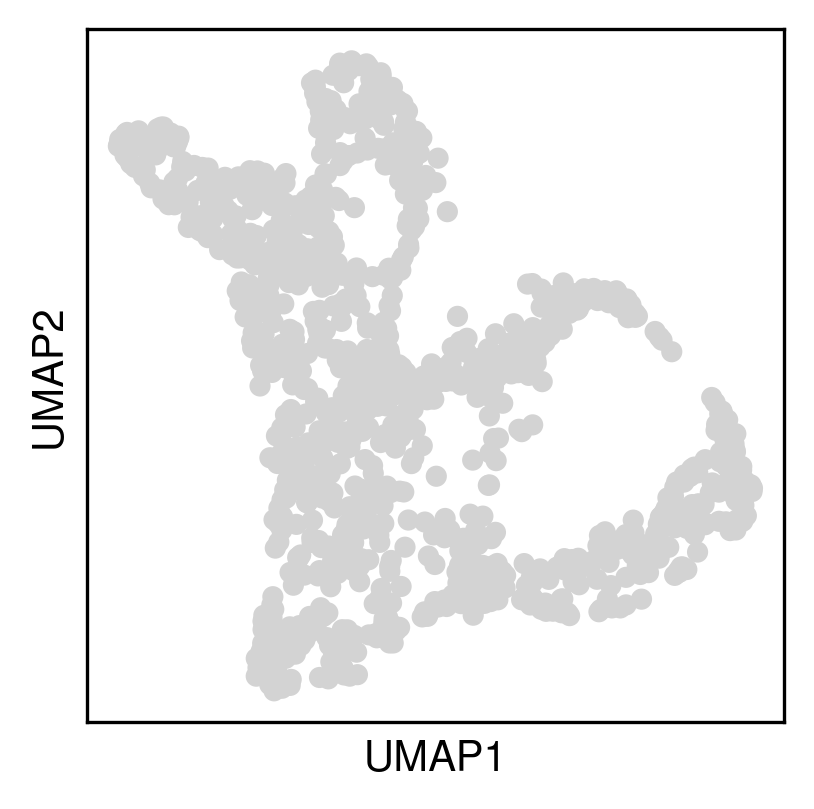

In [8]:
# Load spatial information
img_metadata = utils.preprocess_img(data_path,
                                    sample_id,
                                    adata_index=adata.obs.index,
                                    hchannel=False
                                    )
img, map_info, scalefactor = img_metadata['img'], img_metadata['map_info'], img_metadata['scalefactor']

umap_df = utils.get_umap(adata, display=True)

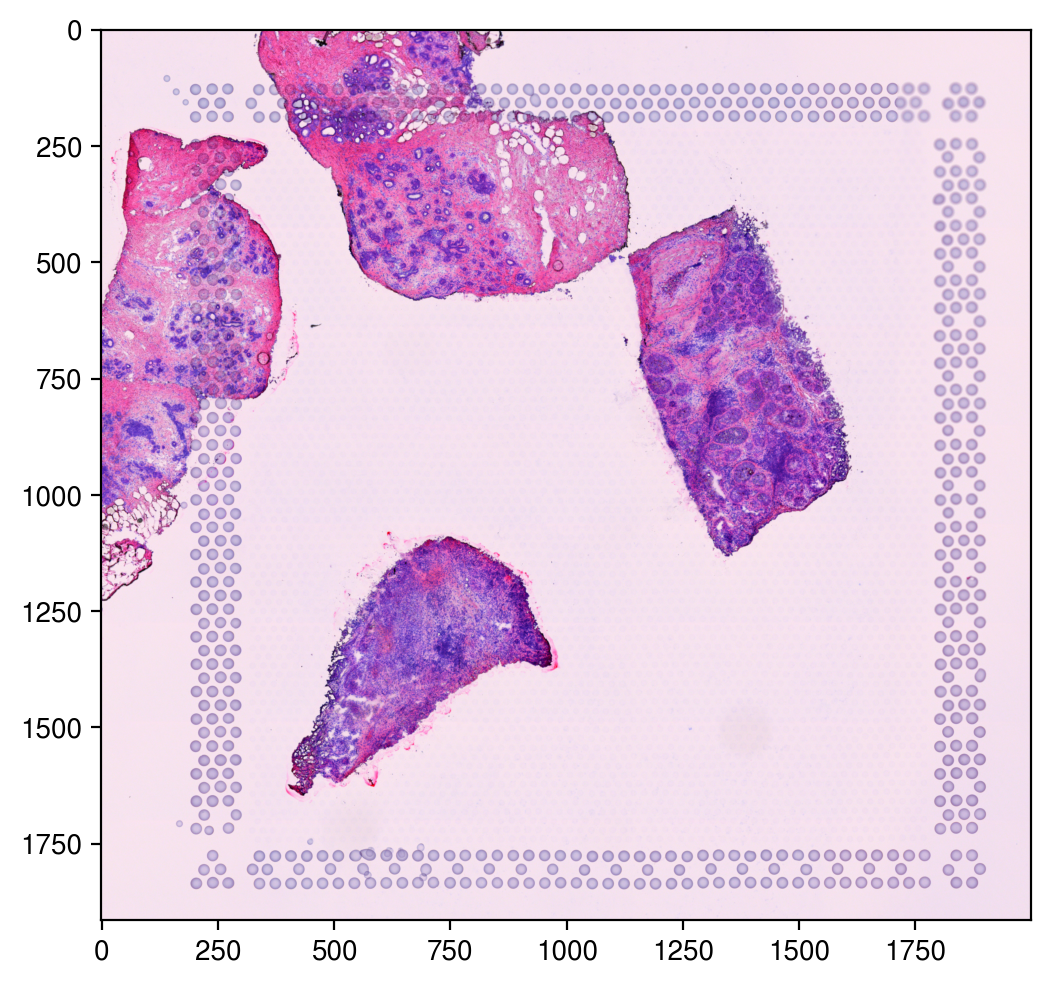

In [9]:
plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(img)
plt.show()

In [10]:
map_info.head()

array_row  array_col    imagerow    imagecol  \
AACATTGGTCAGCCGT-1          3         17  282.131013  520.522390   
CATCGAATGGATCTCT-1          3         19  282.131013  543.117747   
CGGGTTGTAGCTTTGG-1          3         21  282.131013  565.920401   
CCTAAGTGTCTAACCG-1          2         22  262.437812  577.114430   
TCTGTGACTGACCGTT-1          3         23  282.131013  588.515757   

                           sample  
AACATTGGTCAGCCGT-1  CID44971_TNBC  
CATCGAATGGATCTCT-1  CID44971_TNBC  
CGGGTTGTAGCTTTGG-1  CID44971_TNBC  
CCTAAGTGTCTAACCG-1  CID44971_TNBC  
TCTGTGACTGACCGTT-1  CID44971_TNBC

### (2). Preprocessing (finding anchor spots)
- Identify anchor spot locations.

Instantiate parameters for Starfysh model training:
- Raw & normalized counts after taking highly variable genes
- filtered signature genes
- library size & spatial smoothed library size (log-transformed)
- Anchor spot indices (`anchors_df`) for each cell type & their signature means (`sig_means`)


In [11]:
# Parameters for training
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    img_metadata,
                                    n_anchors=60,
                                    window_size=3,
                                    sample_id=sample_id
                                   )

adata, adata_normed = visium_args.get_adata()
anchors_df = visium_args.get_anchors()


[2022-12-11 17:44:13] Subsetting highly variable & signature genes ...
[2022-12-11 17:44:14] Smoothing library size by taking averaging with neighbor spots...
[2022-12-11 17:44:14] Retrieving & normalizing signature gene expressions...
[2022-12-11 17:44:14] Identifying anchor spots (highly expression of specific cell-type signatures)...


- Visualize the spatial data

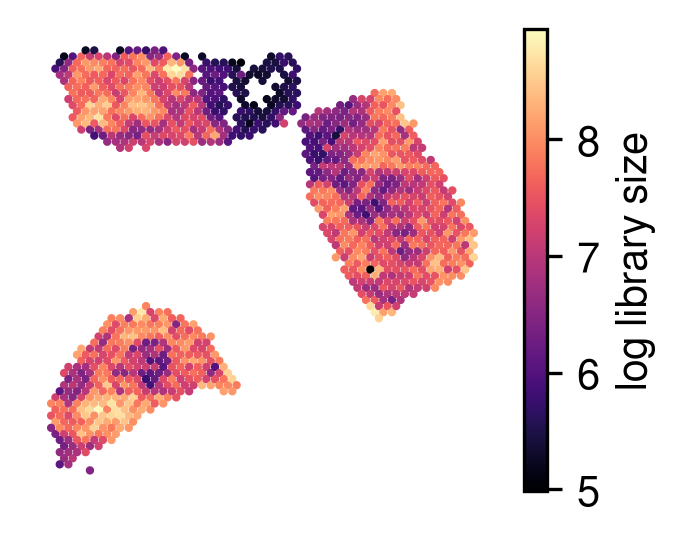

In [12]:
plot_utils.plot_spatial_feature(adata,
                                map_info,
                                visium_args.log_lib,
                                label='log library size'
                               )

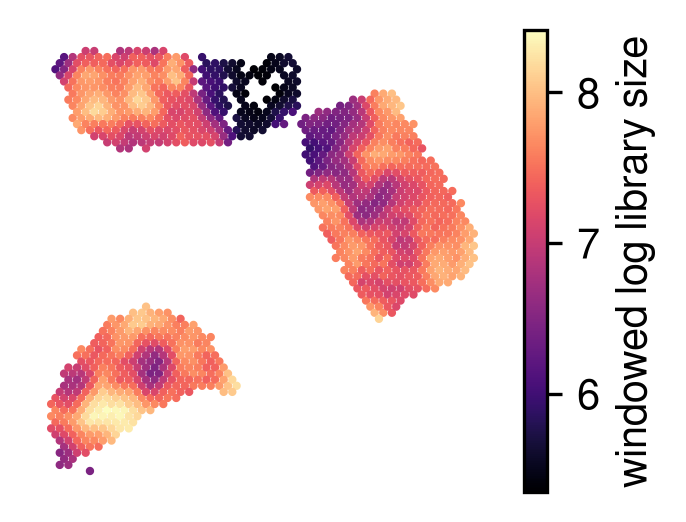

In [13]:
plot_utils.plot_spatial_feature(adata,
                                map_info,
                                visium_args.win_loglib,
                                label='windowed log library size',
                                )

plot raw gene expression:

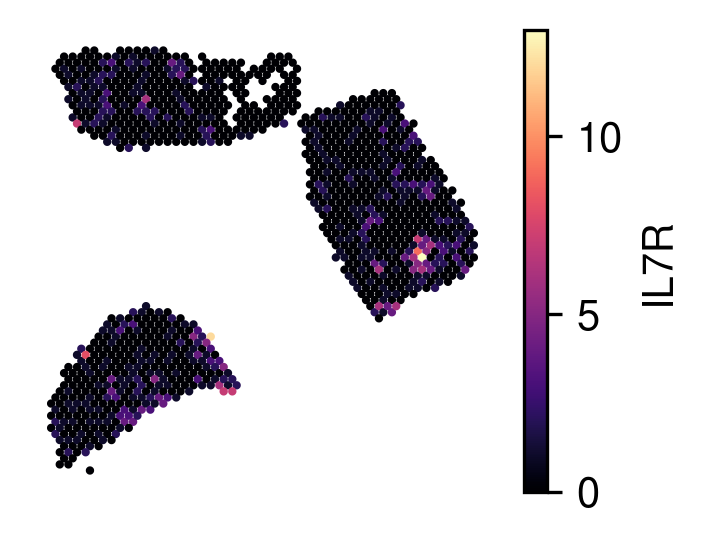

In [14]:
plot_utils.plot_spatial_gene(adata,
                             map_info,
                             gene_name='IL7R')

- Visualize anchor spots

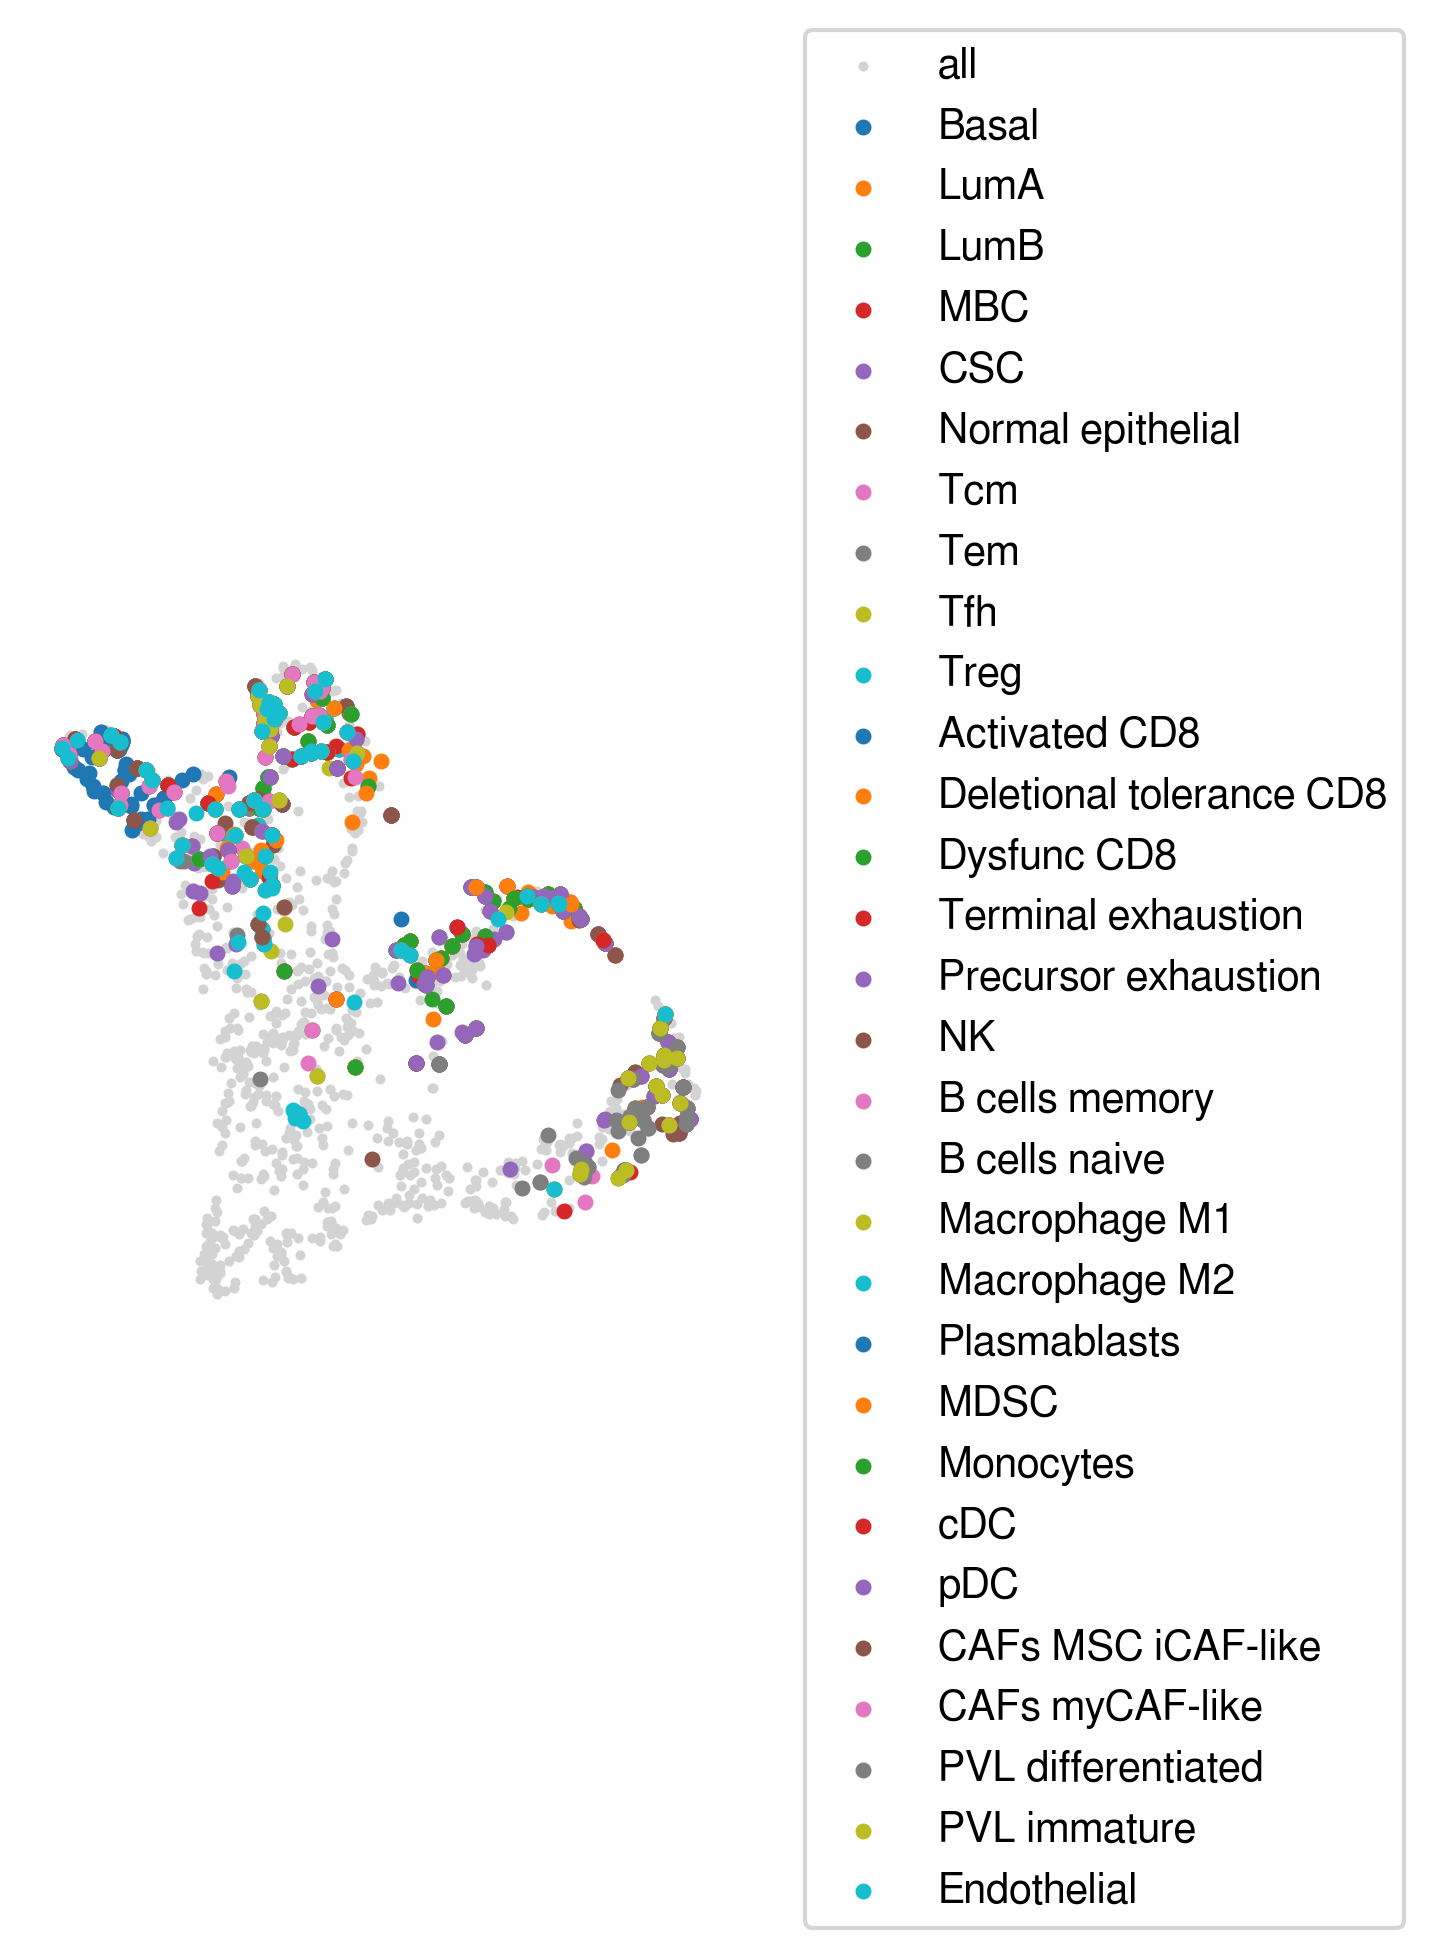

In [15]:
plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )

### (3). Optional: archetypal analysis
Overview:
If users don't provide annotated gene signature sets with cell types, Starfysh annotates cell types with archetypal analysis. The underlying assumption is that the geometric "extremes" are identified as the purest cell types, whereas all other spots are mixture of the "archetypes".<br><br>

If users provide the gene signature sets, it's optional to apply AA to refine marker genes and update anchor spots for known cell types, and identify potential novel cell types / states. Here are the overview features provided by AA:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Find novel cell type / cell states as the most distant archetypes


#### If signature genes aren't provided

```Python
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)

# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Define "signature genes" as marker genes associated with each archetypal cluster
gene_sig = aa_model.find_markers(n_markers=30, display=False)
gene_sig.head()
```


#### If signature genes are provided

In [16]:
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)
# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Find marker genes associated with each archetypal cluster
markers_df = aa_model.find_markers(n_markers=30, display=False)

# (3). Map archetypes to closest anchors (1-1 per cell type)
map_df, map_dict = aa_model.assign_archetypes(anchors_df)

# (4). Optional: Find the most distant archetypes that are not assigned to any annotated cell types
distant_arches = aa_model.find_distant_archetypes(anchors_df, n=3)

[2022-12-11 17:44:16] Computing intrinsic dimension to estimate k...


30 components are retained using conditional_number=30.00


[2022-12-11 17:44:16] Estimating lower bound of # archetype as 12...
[2022-12-11 17:44:29] Calculating UMAPs for counts + Archetypes...
[2022-12-11 17:44:33] Calculating UMAPs for counts + Archetypes...
[2022-12-11 17:44:34] 0.6918 variance explained by raw archetypes.
Merging raw archetypes within 40 NNs to get major archetypes
[2022-12-11 17:44:34] Finding 20 nearest neighbors for each archetype...
[2022-12-11 17:44:35] Finding 30 top marker genes for each archetype...


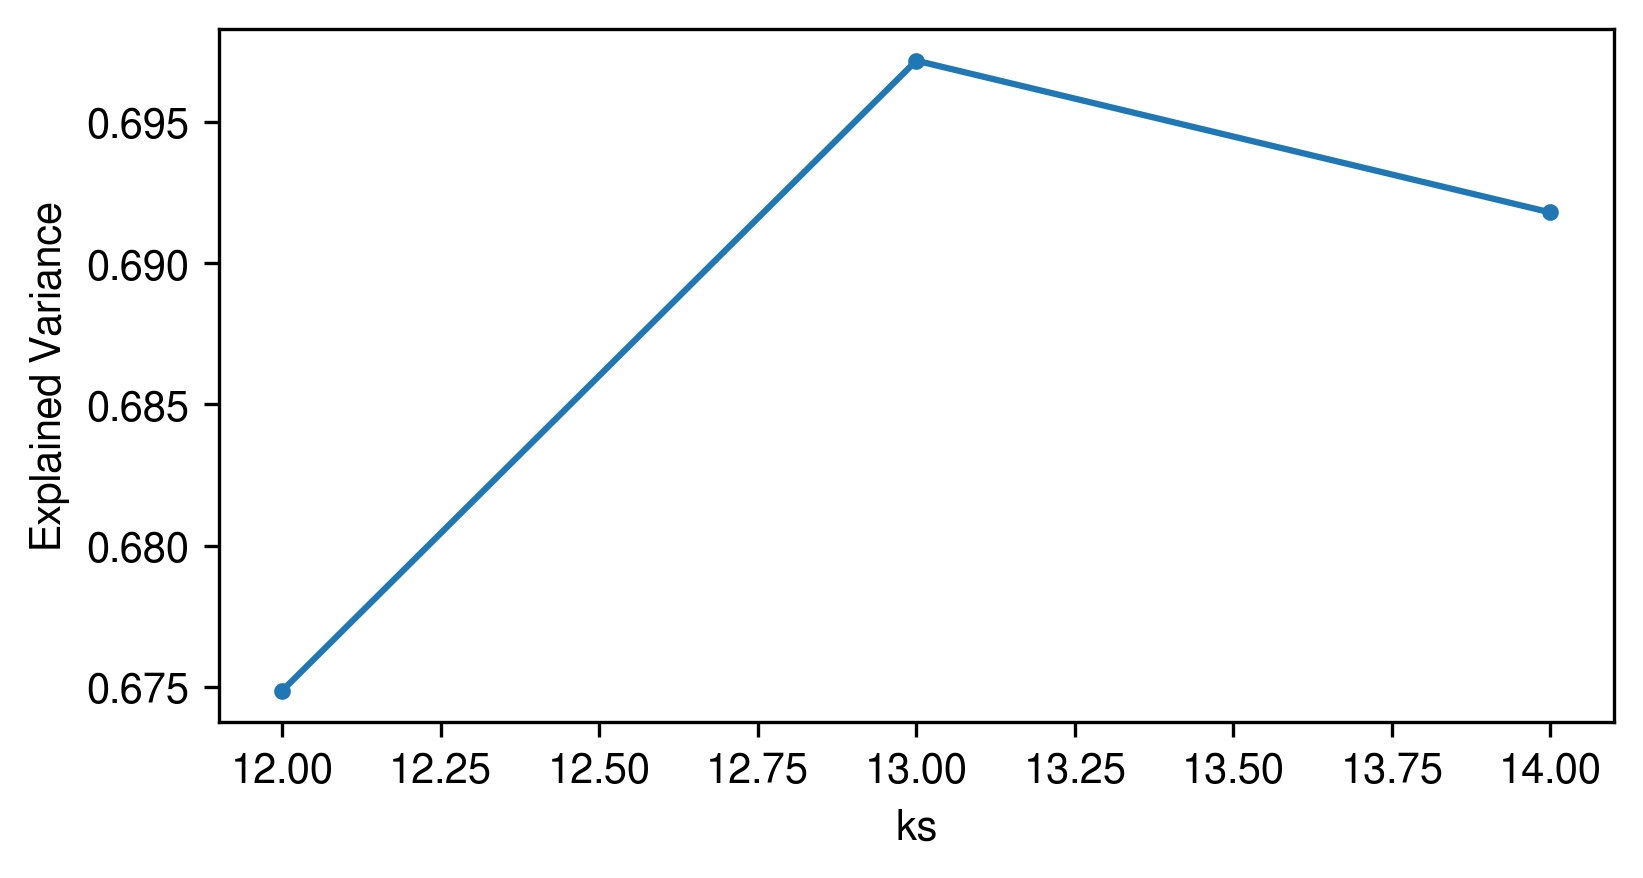

In [17]:
plot_utils.plot_evs(evs, kmin=aa_model.kmin)

- Visualize archetypes

[2022-12-11 17:44:36] No handles with labels found to put in legend.


(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

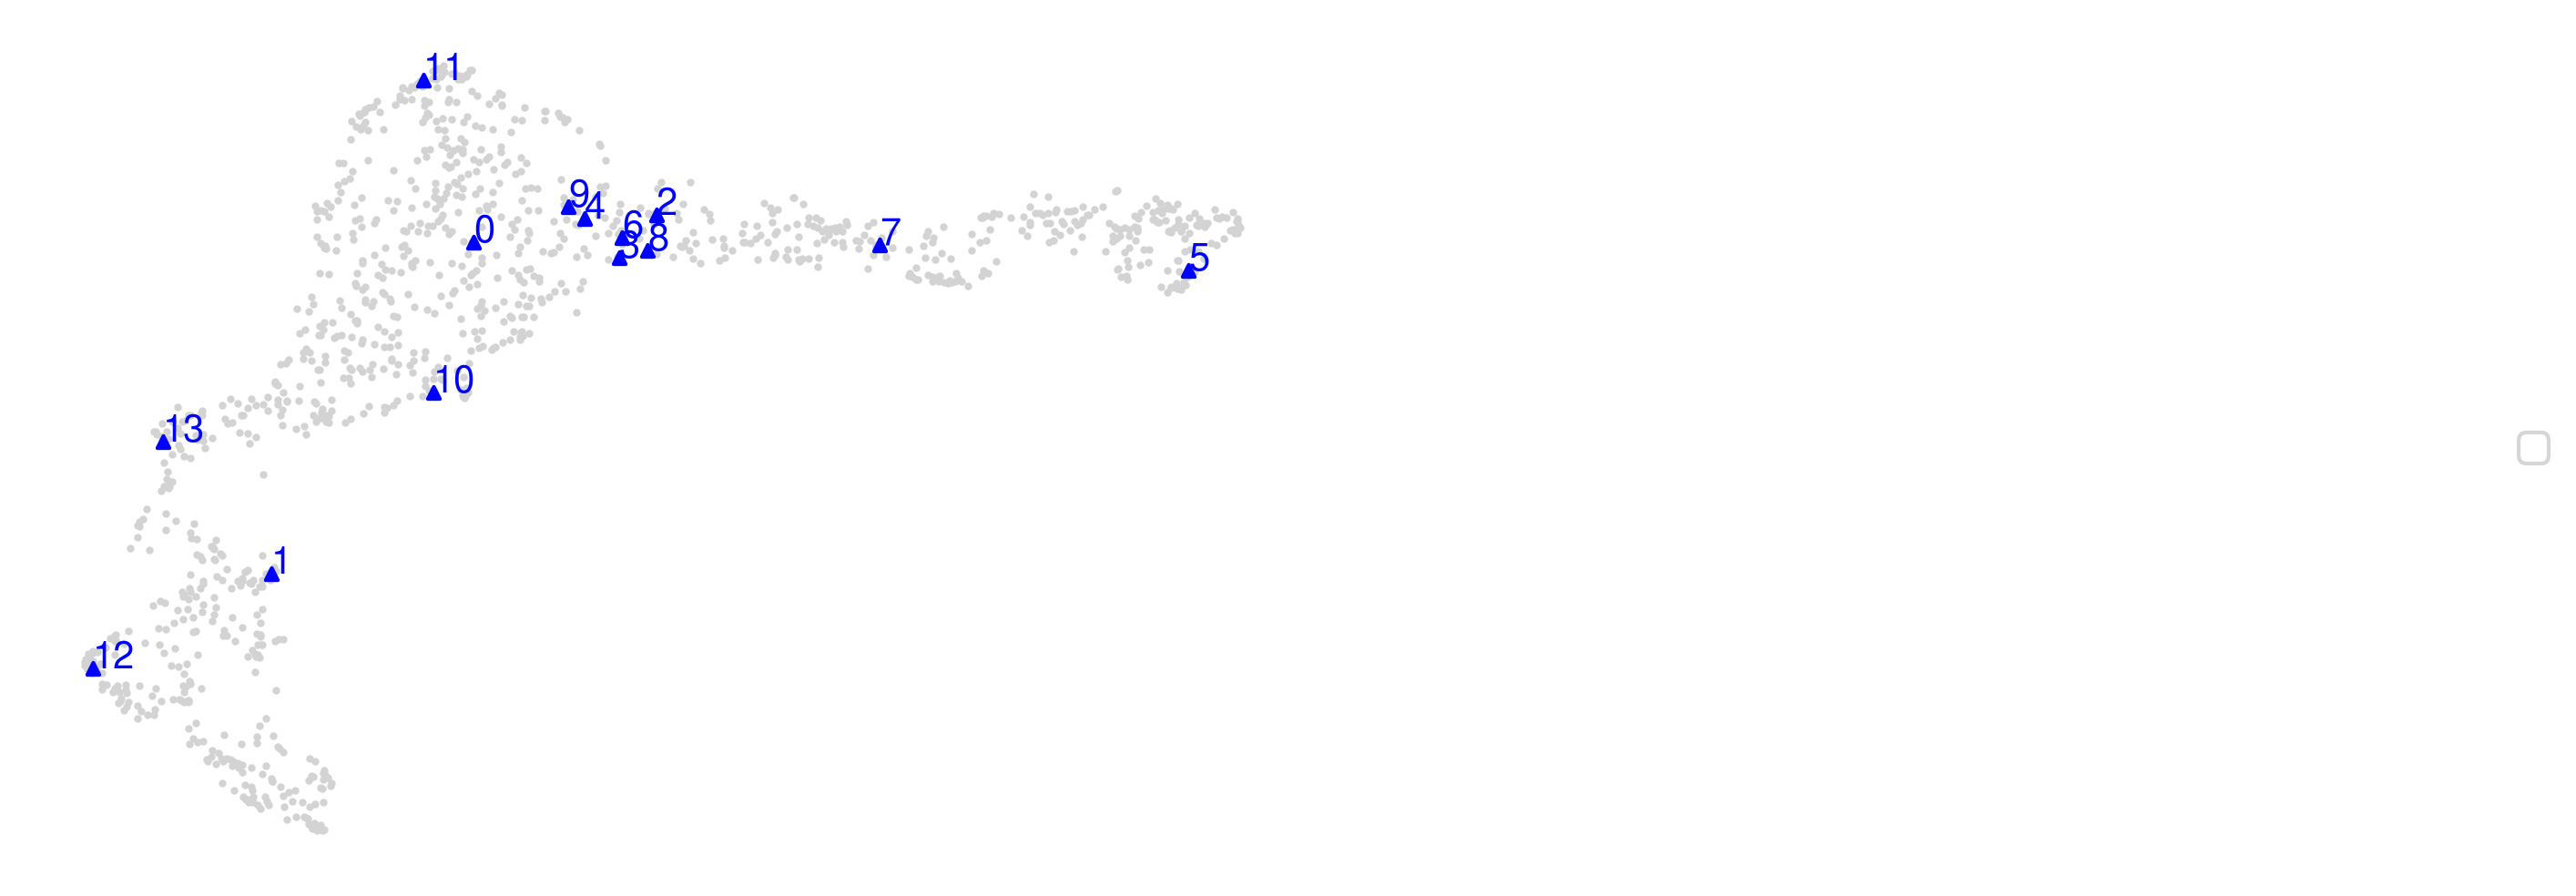

In [18]:
aa_model.plot_archetypes(do_3d=False, major=True, disp_cluster=False)

-  Visualize overlapping ratio between archetypal & anchor spots:


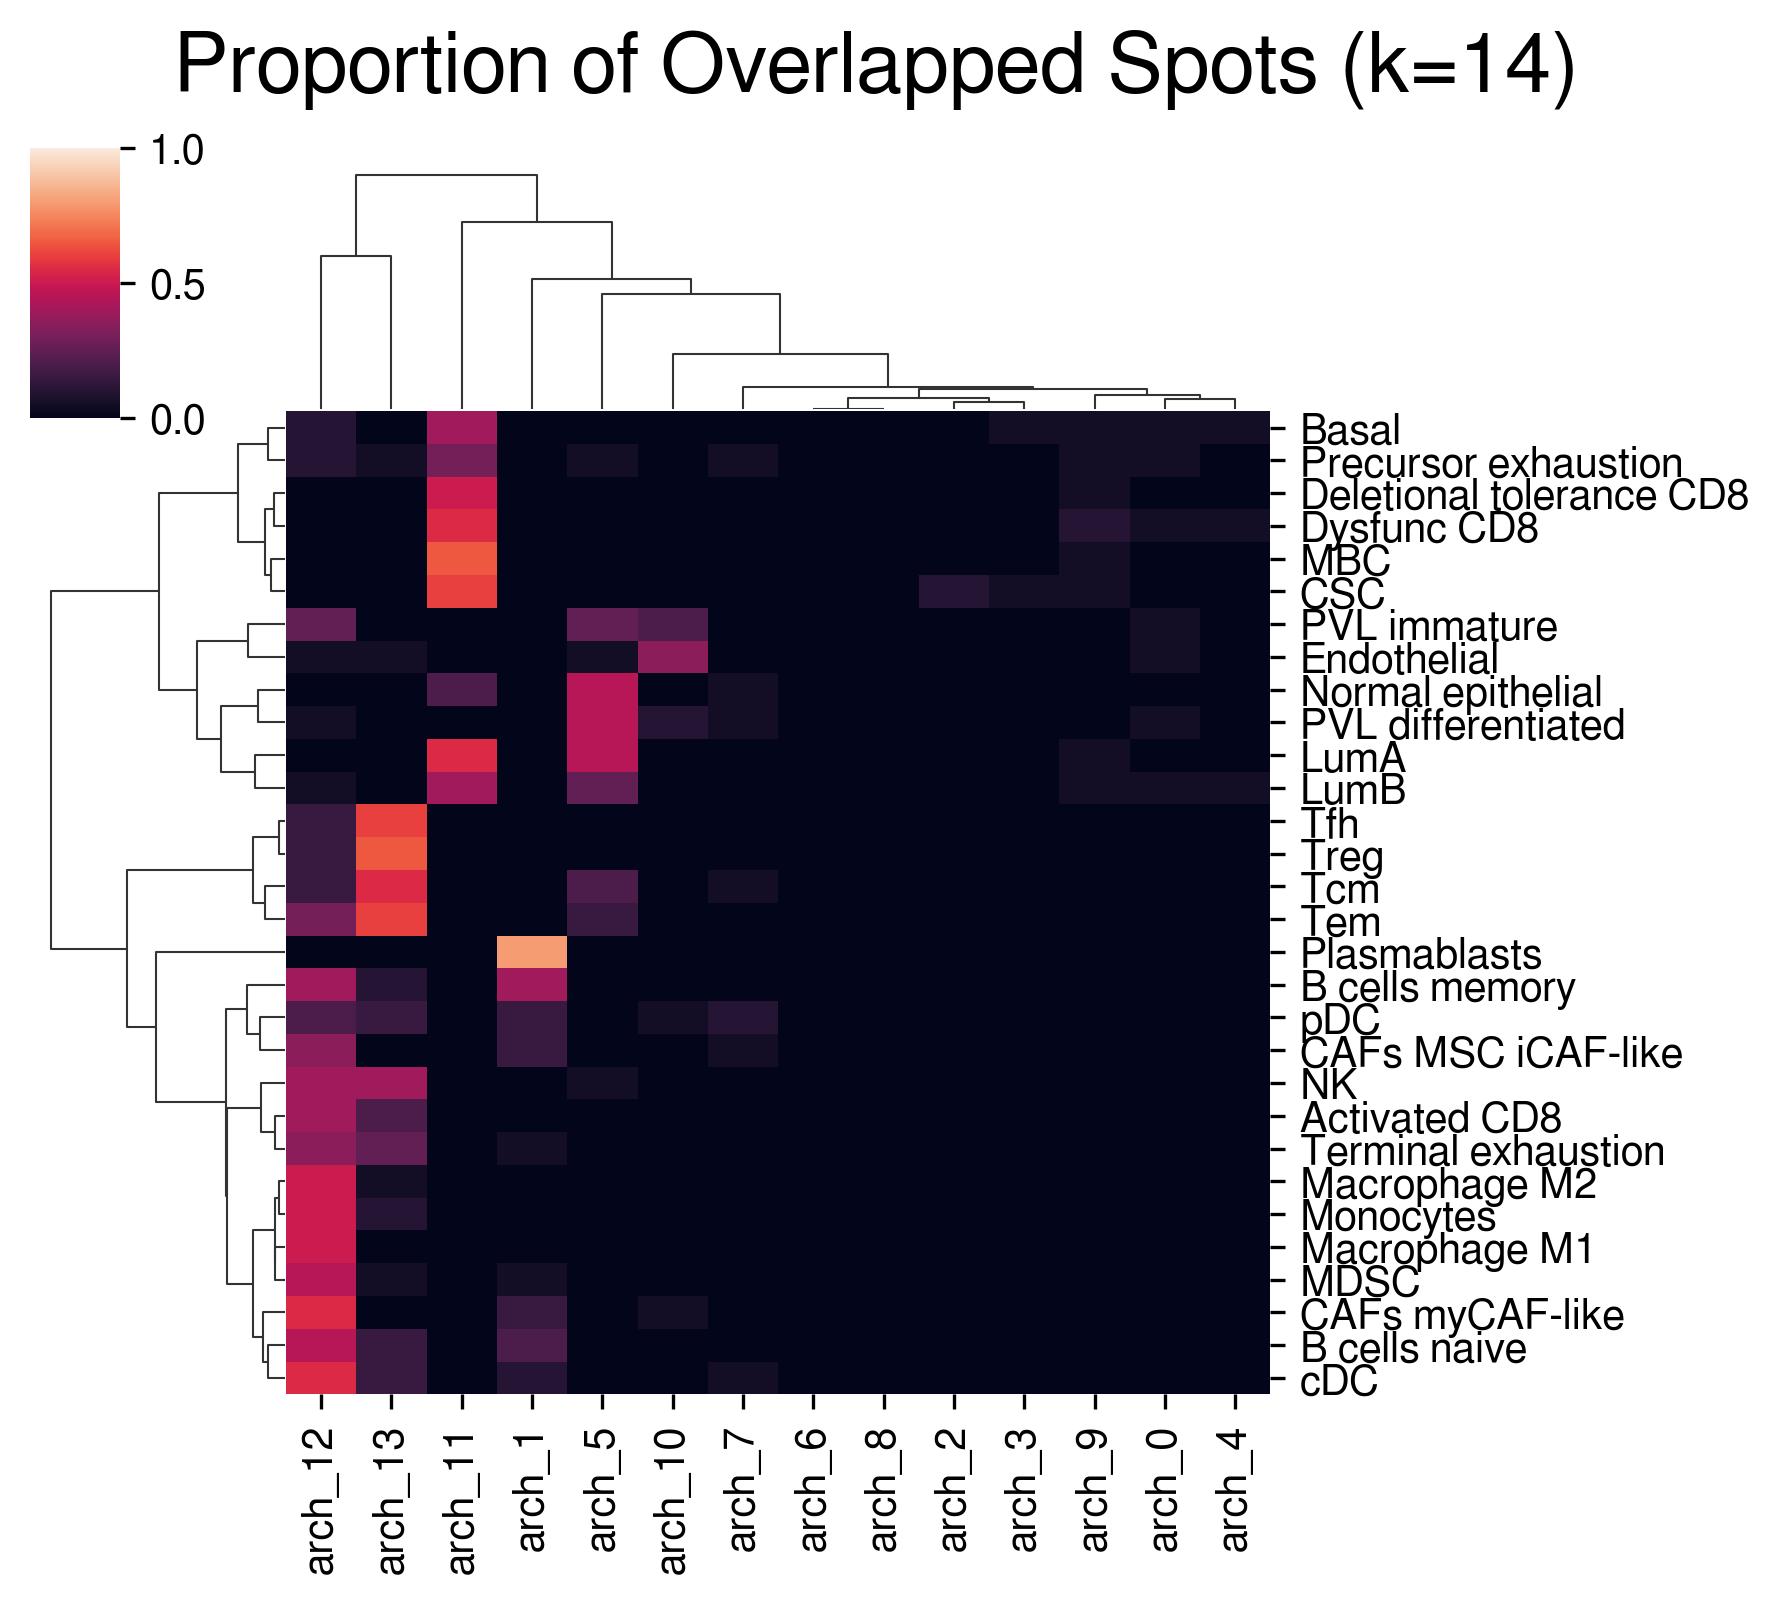

In [19]:
aa_model.plot_mapping(map_df)

-  Application: appending marker genes
   Append archetypal marker genes with the best-aligned anchors:

In [20]:
visium_args = utils.refine_anchors(
    visium_args,
    aa_model,
    n_genes=5,
    n_iters=1
)

[2022-12-11 17:44:37] Finding 50 top marker genes for each archetype...
[2022-12-11 17:44:39] Recalculating anchor spots (highly expression of specific cell-type signatures)...


Refining round 1...
appending 5 genes in arch_11 to Basal...
appending 5 genes in arch_5 to LumA...
appending 5 genes in arch_11 to LumA...
appending 5 genes in arch_11 to LumB...
appending 5 genes in arch_11 to MBC...
appending 5 genes in arch_11 to CSC...
appending 5 genes in arch_5 to Normal epithelial...
appending 5 genes in arch_13 to Tcm...
appending 5 genes in arch_13 to Tem...
appending 5 genes in arch_13 to Tfh...
appending 5 genes in arch_13 to Treg...
appending 5 genes in arch_12 to Activated CD8...
appending 5 genes in arch_11 to Deletional tolerance CD8...
appending 5 genes in arch_11 to Dysfunc CD8...
appending 5 genes in arch_12 to Terminal exhaustion...
appending 5 genes in arch_12 to NK...
appending 5 genes in arch_13 to NK...
appending 5 genes in arch_1 to B cells memory...
appending 5 genes in arch_12 to B cells memory...
appending 5 genes in arch_12 to B cells naive...
appending 5 genes in arch_12 to Macrophage M1...
appending 5 genes in arch_12 to Macrophage M2...


## Run starfysh

We perform `n_repeat` random restarts and select the best model with lowest loss for parameter `c` (inferred cell-type proportions):


### (1). Model parameters

In [21]:
n_repeats = 3
epochs = 100
patience = 10
device = torch.device('cpu')

### (2). Model training

#### Base Starfysh deconvolution with ST count matrix (without PoE)

In [22]:
# Run models
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 patience=patience,
                                 device=device
                                )

[2022-12-11 17:44:39] Running Starfysh with 3 restarts, choose the model with best parameters...
[2022-12-11 17:44:39]  ===  Restart Starfysh 1 === 

[2022-12-11 17:44:39] Initializing model parameters...
[2022-12-11 17:44:46] Epoch[10/100], train_loss: 2895.5009, train_reconst: 1568.8933, train_z: 19.5719,train_c: 1272.2261,train_n: 34.8096
[2022-12-11 17:44:53] Epoch[20/100], train_loss: 2694.7570, train_reconst: 1527.6293, train_z: 19.3562,train_c: 1116.5008,train_n: 31.2707
[2022-12-11 17:45:01] Epoch[30/100], train_loss: 2408.0063, train_reconst: 1491.3492, train_z: 19.5258,train_c: 866.9816,train_n: 30.1497
[2022-12-11 17:45:08] Epoch[40/100], train_loss: 2289.9030, train_reconst: 1468.5714, train_z: 20.2555,train_c: 771.0661,train_n: 30.0100
[2022-12-11 17:45:16] Epoch[50/100], train_loss: 2288.7872, train_reconst: 1442.5097, train_z: 21.0744,train_c: 795.6837,train_n: 29.5194
[2022-12-11 17:45:23] Epoch[60/100], train_loss: 2169.1588, train_reconst: 1424.0789, train_z: 21.3792,

#### Starfysh deconvolution with histology integration (PoE)

We perform integrative inference of both gene expression and histology matrices with Products of Expert model, which projects different data modalities into the joint latent space to aid deconvolution with actual spatial information.

In [23]:
model_poe, loss_poe = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 patience=patience,
                                 poe=True,
                                 device=device
                                 )

[2022-12-11 17:47:25] Running Starfysh with 3 restarts, choose the model with best parameters...
[2022-12-11 17:47:25]  ===  Restart Starfysh 1 === 

[2022-12-11 17:47:25] Initializing model parameters...
[2022-12-11 17:47:40] Epoch[10/100], train_loss: 5163086.5811, train_reconst: 1655.1332, train_z: 19.4501,train_c: 1211.2514,train_n: 31.7122
[2022-12-11 17:47:54] Epoch[20/100], train_loss: 1742500.0380, train_reconst: 1598.3157, train_z: 18.4168,train_c: 980.7925,train_n: 28.7902
[2022-12-11 17:48:09] Epoch[30/100], train_loss: 652715.0739, train_reconst: 1551.8520, train_z: 17.6684,train_c: 857.2219,train_n: 26.4407
[2022-12-11 17:48:23] Epoch[40/100], train_loss: 371161.8961, train_reconst: 1531.2947, train_z: 17.4863,train_c: 774.2421,train_n: 25.2044
[2022-12-11 17:48:37] Epoch[50/100], train_loss: 334056.1888, train_reconst: 1504.4072, train_z: 17.5587,train_c: 774.4865,train_n: 24.2173
[2022-12-11 17:48:51] Epoch[60/100], train_loss: 311895.6296, train_reconst: 1492.3685, trai

### (3). Downstream analysis

#### Parse Starfysh inference output (**Starfysh without PoE**)

In [24]:
inference_outputs, generative_outputs, px = starfysh.model_eval(model,
                                                                adata,
                                                                visium_args.sig_mean,
                                                                device,
                                                                visium_args.log_lib,
                                                               )
u = post_analysis.get_z_umap(inference_outputs, map_info)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

With PoE:

In [25]:
inference_outputs_poe = model_poe.inference(torch.Tensor(adata.to_df().values).to(device))
img_outputs = model_poe.predict_imgVAE(torch.Tensor(visium_args.get_img_patches()).float().to(device))
sig_means = torch.Tensor(visium_args.sig_mean_znorm.values).to(device)
generative_outputs_poe = model_poe.generative(
    inference_outputs,
    sig_means,
    img_outputs
)

u = post_analysis.get_z_umap(inference_outputs_poe, map_info)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

#### Visualize starfysh deconvolution results

##### Gene sig mean vs. inferred prop


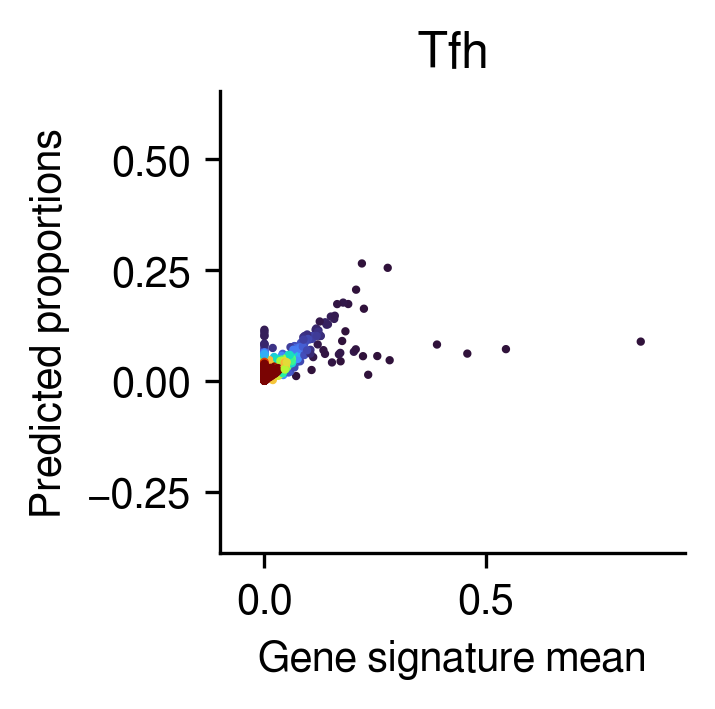

In [26]:
n_cell_types = gene_sig.shape[1]
idx = np.random.randint(0, n_cell_types)
post_analysis.gene_mean_vs_inferred_prop(inference_outputs,
                                         visium_args,
                                         idx=idx
                                        )

##### Spatial visualizations:

Inferred density on Spatial map:

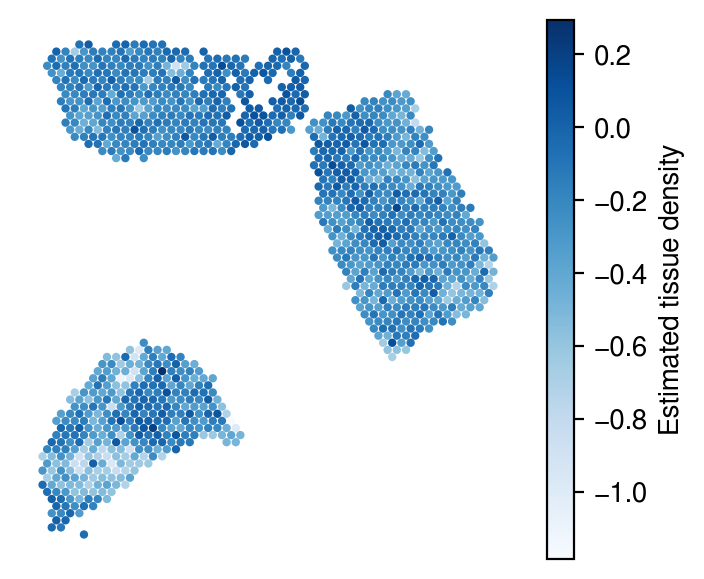

In [27]:
plot_utils.pl_spatial_inf_feature(adata,
                                  map_info,
                                  inference_outputs,
                                  feature='ql_m',
                                  idx=0,
                                  plt_title='',
                                  label='Estimated tissue density',
                                  s=4,
                                  cmap='Blues'
                                  #vmax=3
                                 )

Inferred cell-type proportions (spatial map):

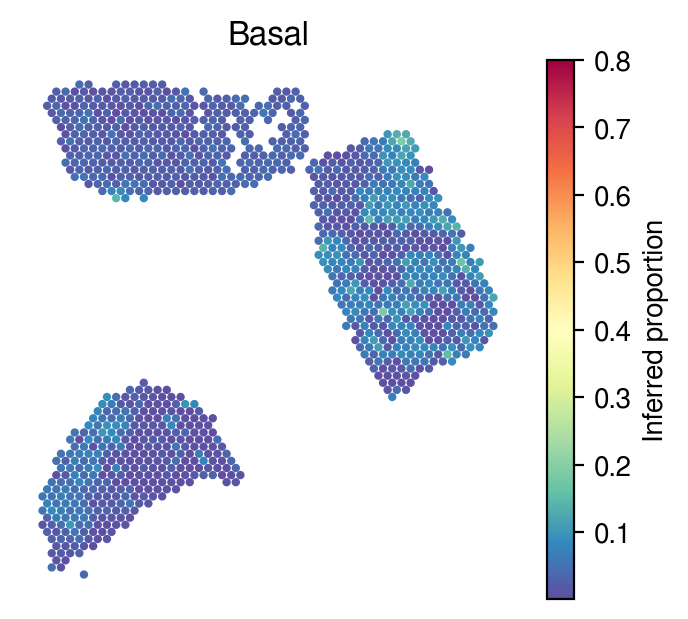

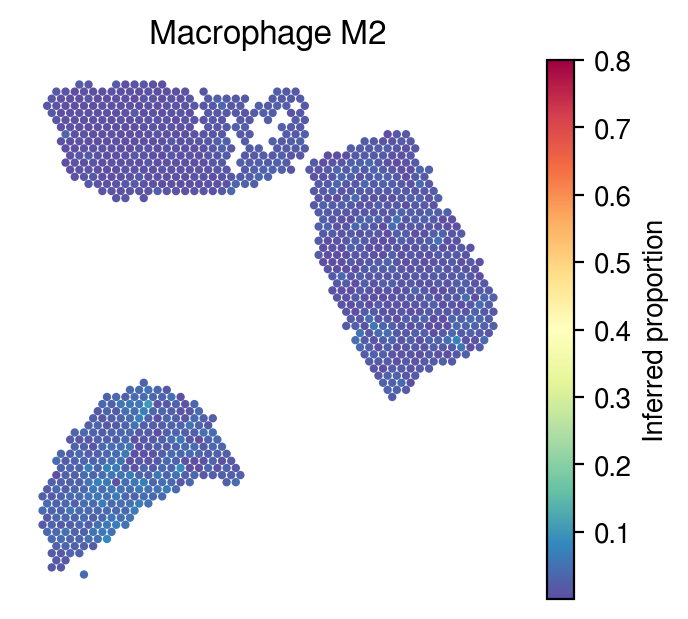

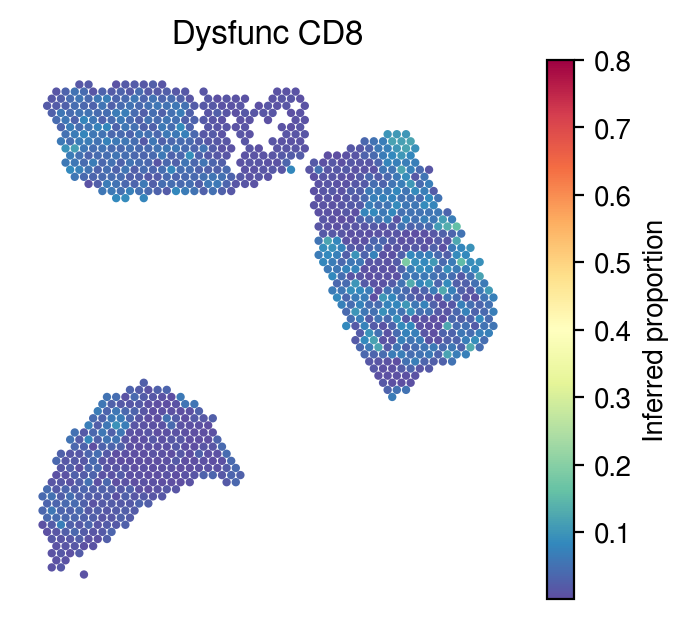

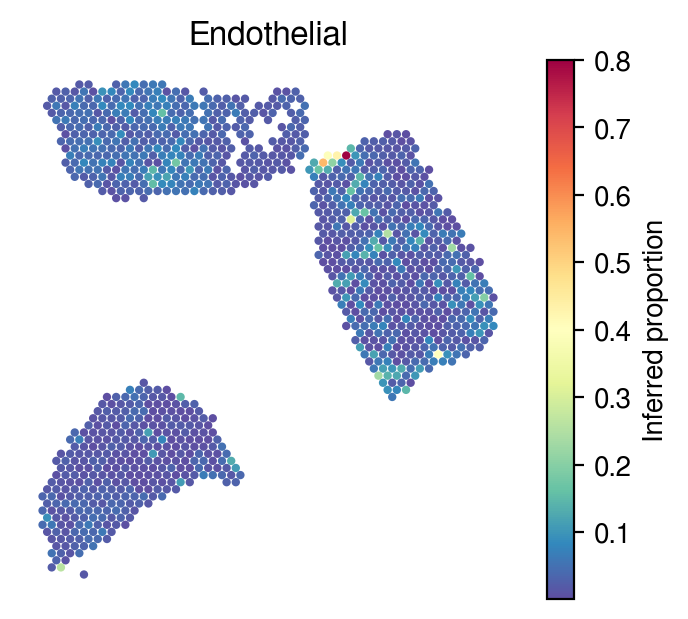

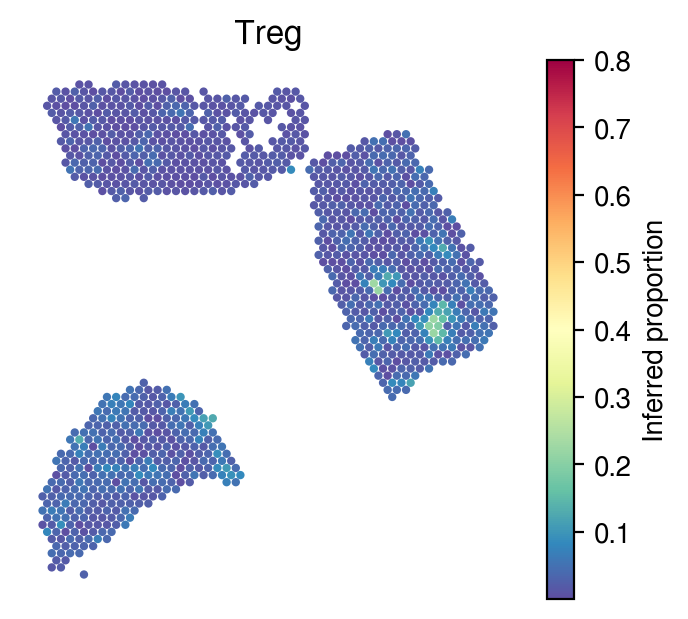

In [28]:
# Randomly choose cell types to visualize
celltype_indices = np.random.randint(0, n_cell_types, size=5)

for idx in celltype_indices:

    # Inferred proportions on ST spatial coordinates
    plot_utils.pl_spatial_inf_feature(adata,
                       map_info,
                       inference_outputs,
                       feature='qc_m',
                       idx=idx,
                       plt_title=gene_sig.columns[idx],
                       label='Inferred proportion',
                       s=4,
                       vmax=0.8
                       )


Inferred cell-type proportions on Z-space (UMAP):

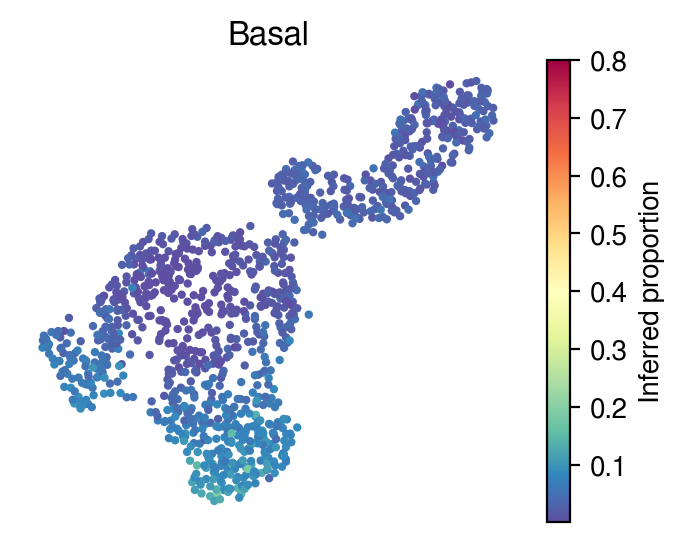

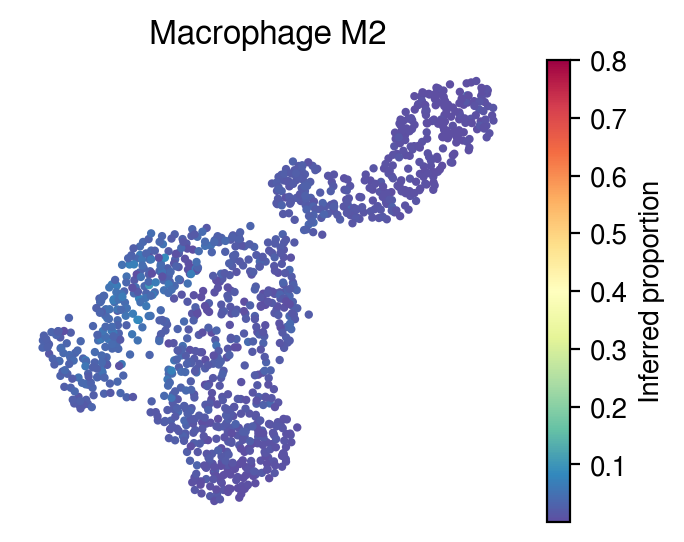

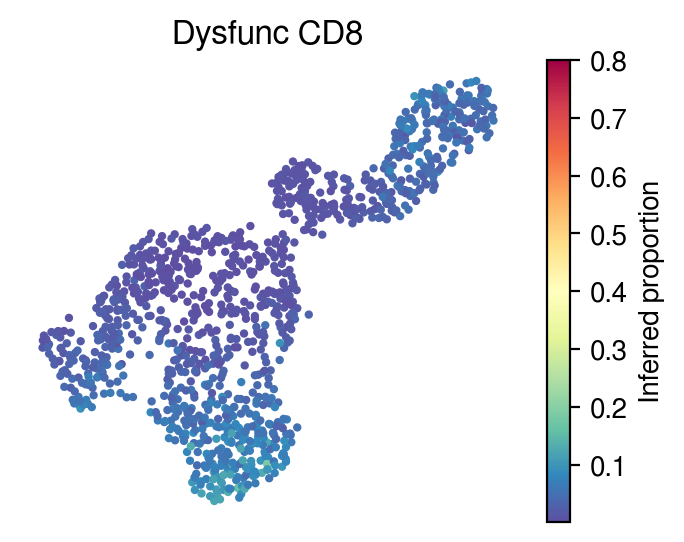

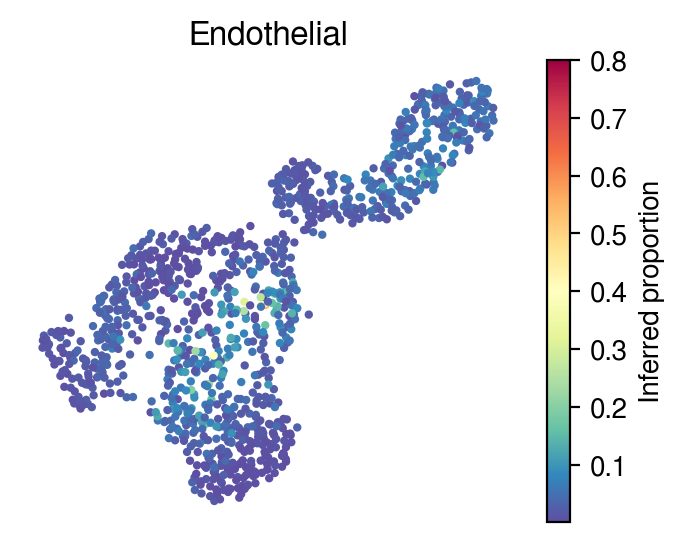

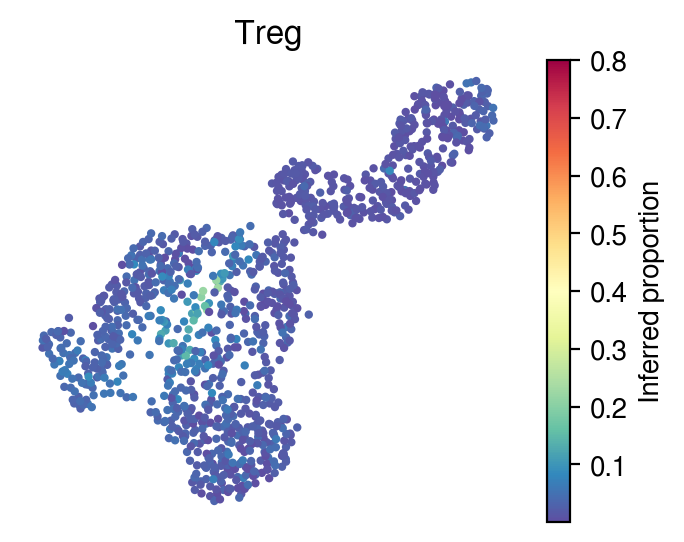

In [29]:
for idx in celltype_indices:

    # Inferred proportions on starfysh learnt latent dimension
    plot_utils.pl_umap_feature(adata,
                   u,
                   inference_outputs,
                   feature='qc_m',
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=4,
                   vmax=0.8)

##### Infer cell-type specific expressions for each spot

In [30]:
pred_exp = {}
for i, label in enumerate(gene_sig.columns):
    pred_exp[label] = starfysh.model_ct_exp(model,
                                            adata,
                                            visium_args.sig_mean_znorm,
                                            device,
                                            visium_args.log_lib,
                                            ct_idx=i
                                           ).tolist()


Plot spot-level expression of `IL7R` from *Effector Memory T cells (Tem)*:


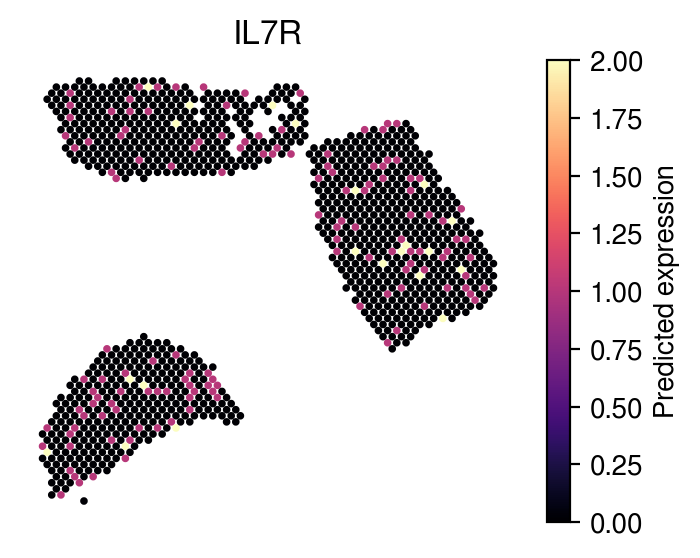

In [31]:
sample_gene = 'IL7R'
sample_cell_type = 'Tem'
idx = list(adata.var_names[adata.var['highly_variable']]).index(sample_gene)

plot_utils.pl_spatial_inf_gene(adata,
                   map_info,
                   feature=np.asarray(pred_exp[sample_cell_type]),
                   idx= idx,
                   plt_title=list(adata.var_names[adata.var['highly_variable']])[idx],
                   label='Predicted expression',
                   s=3,
                   vmax=2)


#### Parse Starfysh inference output (**Starfysh w/ PoE**)

In [32]:
inference_outputs_poe = model_poe.inference(torch.Tensor(adata.to_df().values).to(device))
img_outputs = model_poe.predict_imgVAE(torch.Tensor(visium_args.get_img_patches()).float().to(device))
sig_means = torch.Tensor(visium_args.sig_mean_znorm.values).to(device)
generative_outputs_poe = model_poe.generative(
    inference_outputs,
    sig_means,
    img_outputs
)

u = post_analysis.get_z_umap(inference_outputs_poe, map_info)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

#### Visualize starfysh deconvolution results (w/ PoE)

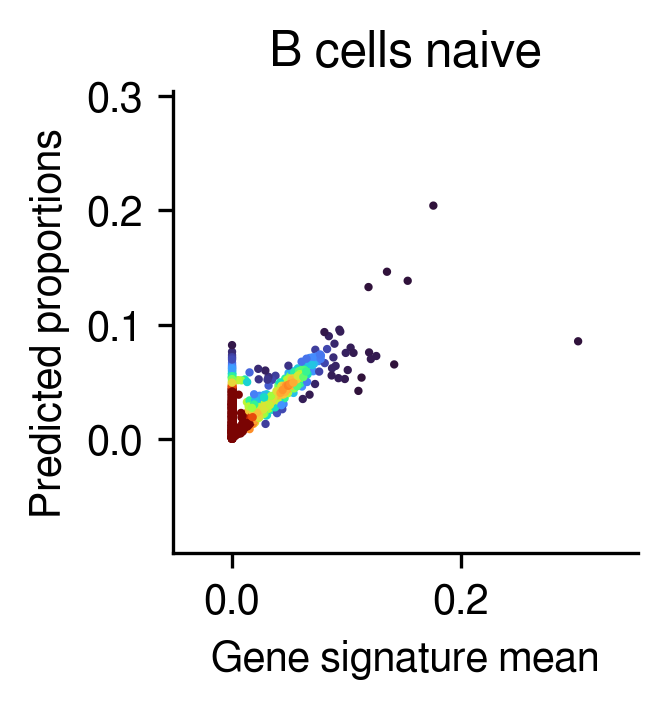

In [35]:
idx = np.random.randint(0, n_cell_types)
post_analysis.gene_mean_vs_inferred_prop(inference_outputs_poe,
                                         visium_args,
                                         idx=idx
                                        )

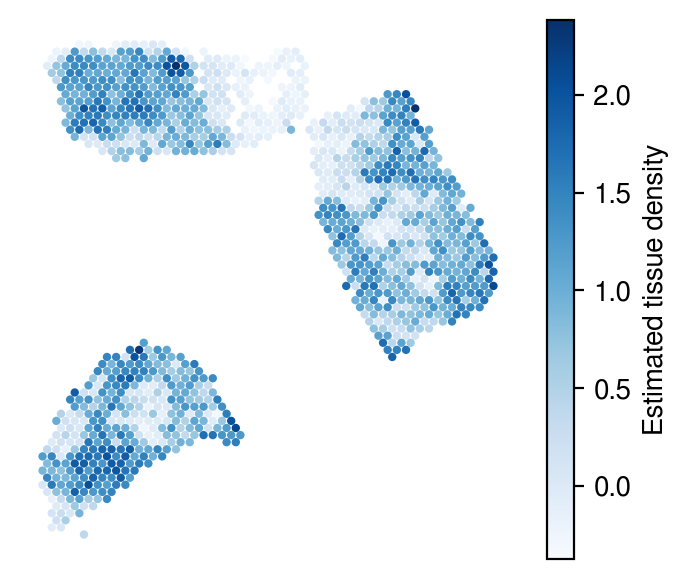

In [36]:
plot_utils.pl_spatial_inf_feature(adata,
                                  map_info,
                                  inference_outputs_poe,
                                  feature='ql_m',
                                  idx=0,
                                  plt_title='',
                                  label='Estimated tissue density',
                                  s=4,
                                  cmap='Blues'
                                 )

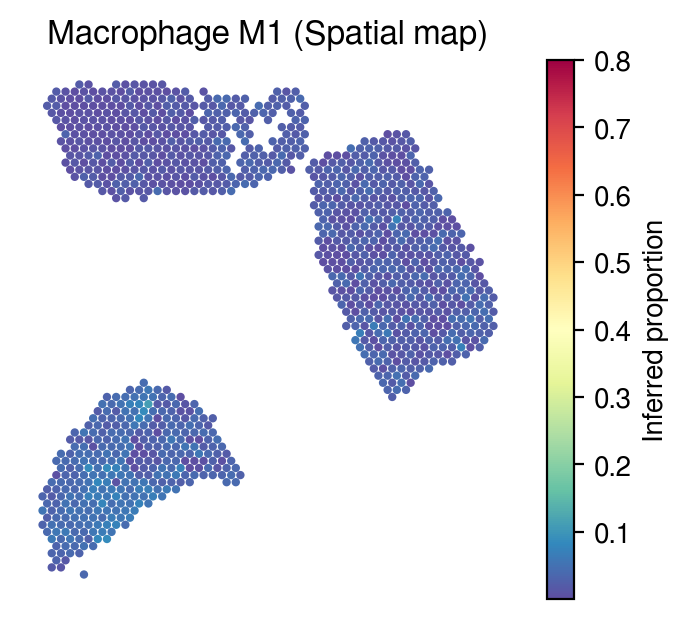

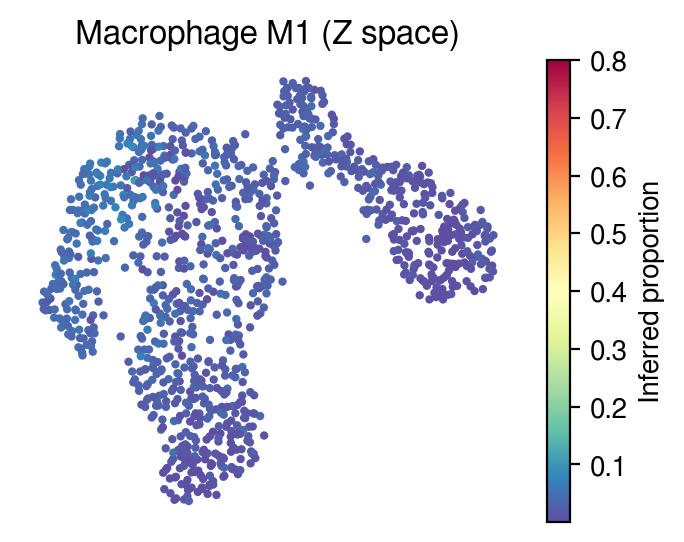

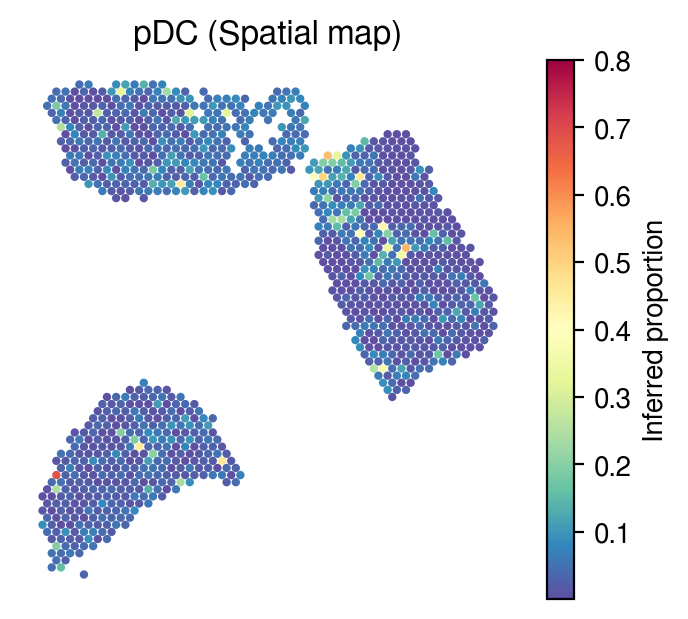

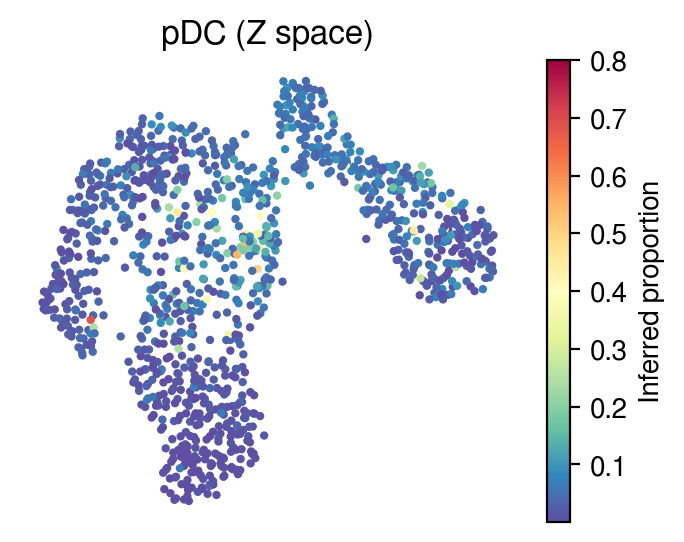

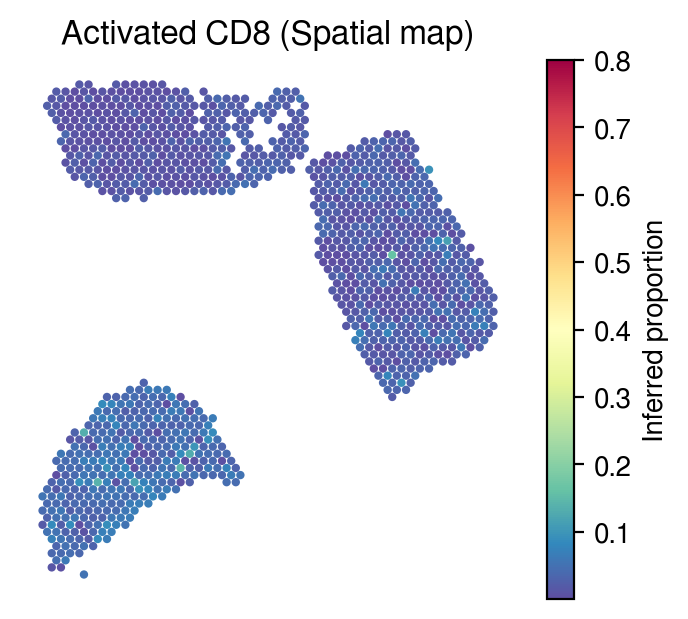

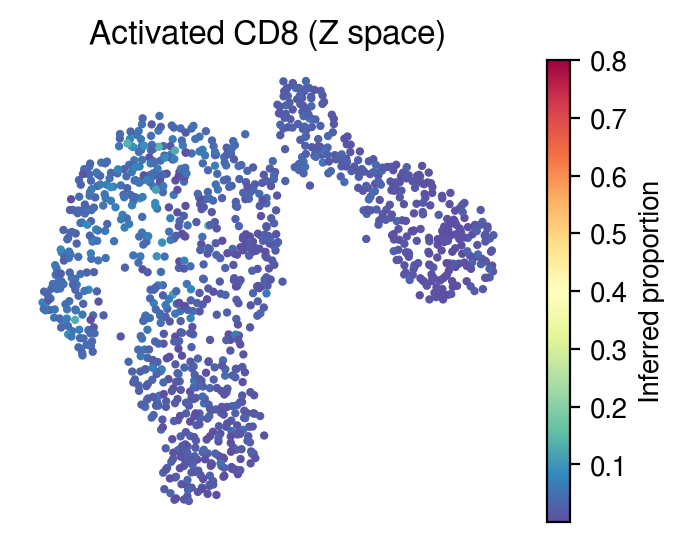

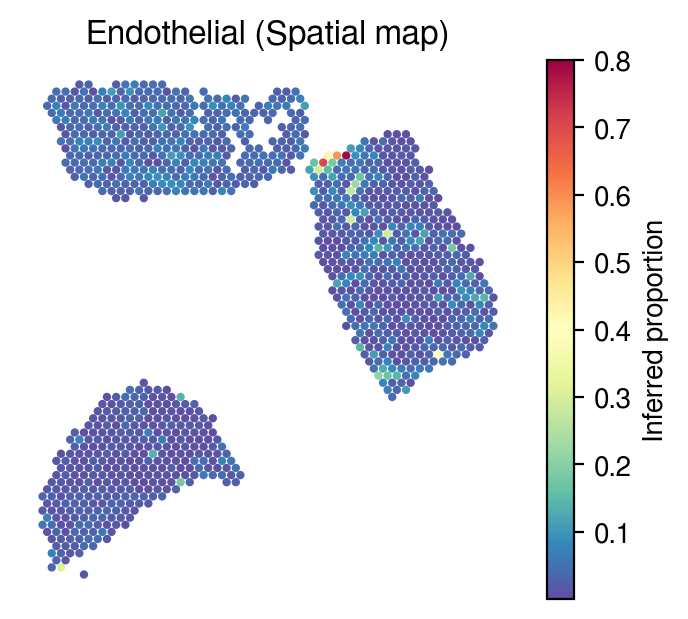

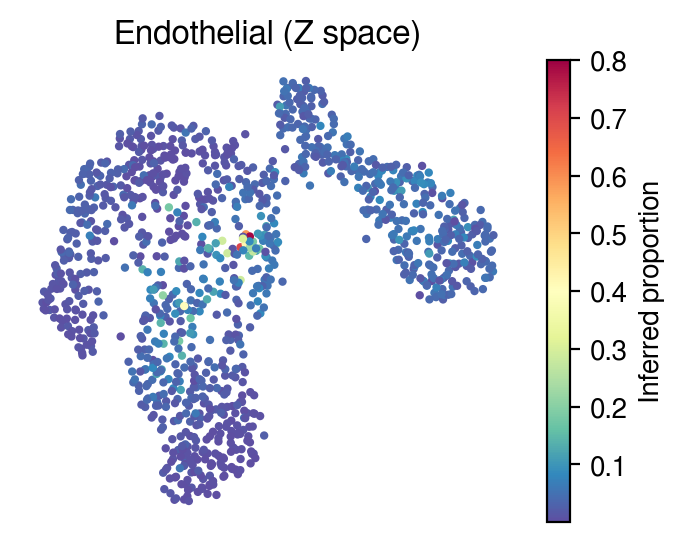

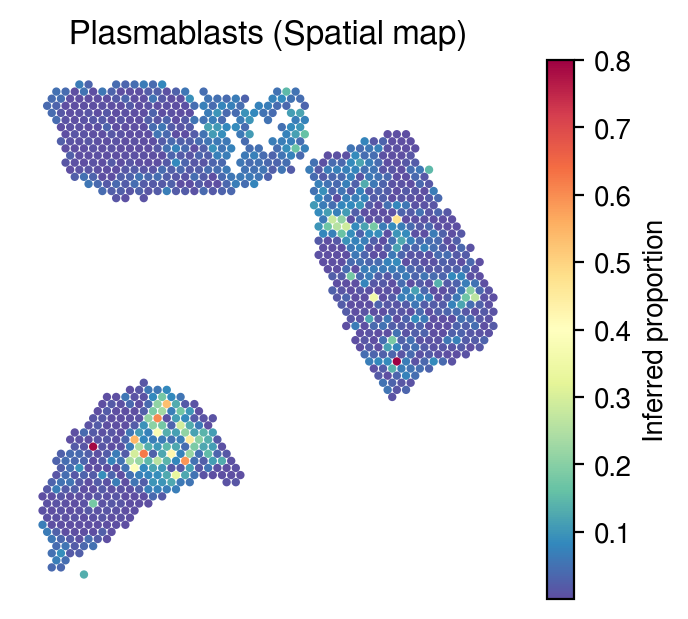

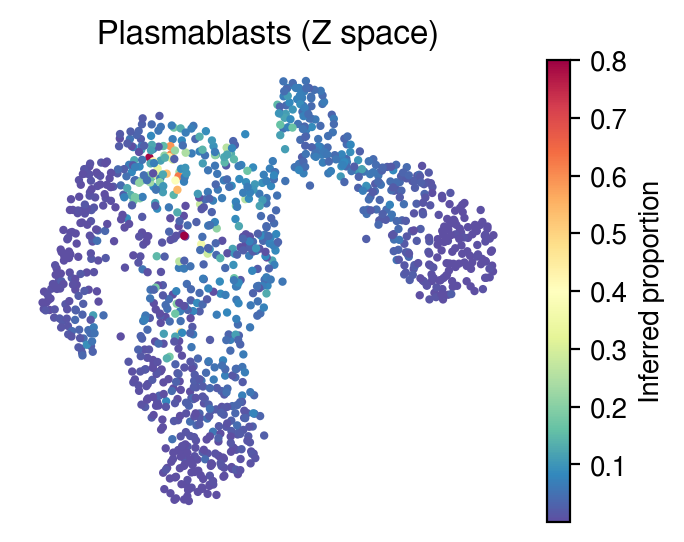

In [39]:
# Randomly choose cell types to visualize
celltype_indices = np.random.randint(0, n_cell_types, size=5)

for idx in celltype_indices:

    # Inferred proportions on ST spatial coordinates
    plot_utils.pl_spatial_inf_feature(adata,
                       map_info,
                       inference_outputs_poe,
                       feature='qc_m',
                       idx=idx,
                       plt_title=gene_sig.columns[idx] + ' (Spatial map)',
                       label='Inferred proportion',
                       s=4,
                       vmax=0.8
                       )

    # Inferred proportions on starfysh learnt latent dimension
    plot_utils.pl_umap_feature(adata,
                   u,
                   inference_outputs_poe,
                   feature='qc_m',
                   idx=idx,
                   plt_title=gene_sig.columns[idx] + ' (Z space)',
                   label='Inferred proportion',
                   s=4,
                   vmax=0.8)

---